In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

In [2]:
# Create known parameters
weight = 0.7
bias = 0.3

# create some data
start = 0
end = 1
gap = 0.02
X = torch.arange(start, end, gap).unsqueeze(dim=1)
Y = weight * X + bias

### Splitting data into training and test sets (one of the most important concepts in machine learning in general)

In [3]:
# We take 80% of it
train_split = int(0.8*len(X))
X_train, Y_train = X[:train_split], Y[:train_split]
X_test, Y_test = X[train_split:], Y[train_split:]

### Visuallize our data

In [4]:
def plot_predictions(train_data = X_train, train_labels = Y_train, test_data = X_test, test_labels = Y_test, predictions = None):

    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c='b', s=4, label="Training Data")

    # Plot testing data in green
    plt.scatter(test_data, test_labels, c='g', s=4, label="Testing data")

    # Are they predictions?
    if predictions is not None:
        
        # Plot the predictions if they exist
        plt.scatter(test_data, predictions, c='r', s=4, label="Predictions")
    
    #Show the legends
    plt.legend(prop={"size":14});


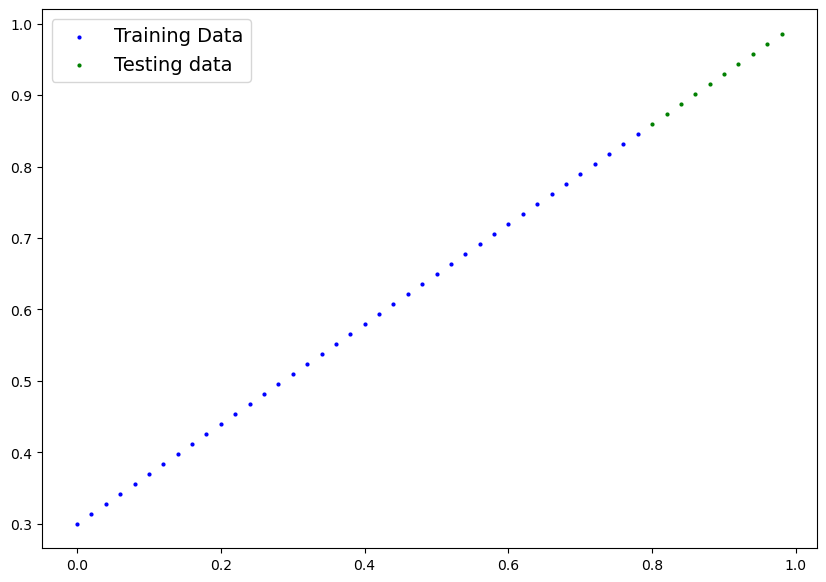

In [5]:
plot_predictions()

### Building our model
**Our first model!!**

#### What our model will do:
* Start with a random number
* Look at training data and adjust the random values to better represent the ideal values

#### How does it do so?
1. Gradient descent
2. Backpropadation

In [6]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

### Making predictions we using `torch.inference_mode()`

In [7]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an ibstance of the model 
model0 = LinearRegressionModel()

## Make predictions with model
with torch.inference_mode(): 
    Y_preds = model0(X_test)

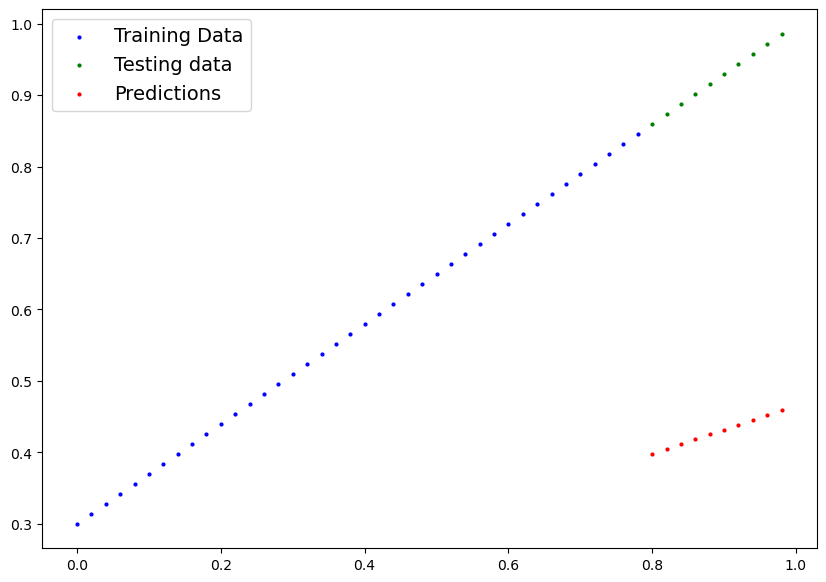

In [8]:
# Plot predictions
plot_predictions(predictions=Y_preds)

### Train model

Thew hole idea of training is for a model from some *unknown* parameter to some *known* parameter.

Or in other words from  poor representation of the data to a better representation of the data.

One way to measure how wrong our models predictions are isto use *loss* function.

In [13]:
model0.state_dict(), model0.parameters()

(OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))]),
 <generator object Module.parameters at 0x16b158d60>)

Things we need to train:
 * Optimizer
    * Inside the optimizer you will often have to set two parameters:
      * `params` - the model parameters you would like to optimize, for example `params = model0_parameters()`
      * `lr` - learning rate define how big/small thr optimizer changes the parameters with each step
 * Loss Function

 And specifically for PyTorch we need:
 * A training loop
 * A testing loop

In [14]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Setup a optimizer
optimizer = torch.optim.Adam(params=model0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

In [16]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, Y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, Y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")